### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [35]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
import statsmodels.formula.api as smf
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [36]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
101,NSW102,1,26,10,1,0,0,1,0.000,0.0000,9265.788
260,PSID76,0,26,12,0,1,0,0,7968.338,5109.5810,4181.966
600,PSID416,0,34,12,1,0,0,0,0.000,0.0000,0.000
109,NSW110,1,26,10,1,0,1,1,2027.999,0.0000,0.000
143,NSW144,1,46,8,1,0,0,1,3165.658,2594.7230,0.000
515,PSID331,0,24,12,1,0,1,0,2355.039,0.0000,2448.593
332,PSID148,0,24,10,0,0,1,1,4719.874,2565.5320,2173.736
49,NSW50,1,23,12,1,0,0,0,0.000,0.0000,4843.176
461,PSID277,0,19,10,1,0,0,1,1056.045,205.8871,0.000
283,PSID99,0,28,12,1,0,0,0,16722.340,4253.8060,7314.747


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

Average increase in salary in 1978 when compared with the average from 1974-1975 for trained people:  4535.3290290540535
Median increase in salary in 1978 when compared with the average from 1974-1975 for trained people:  2321.107


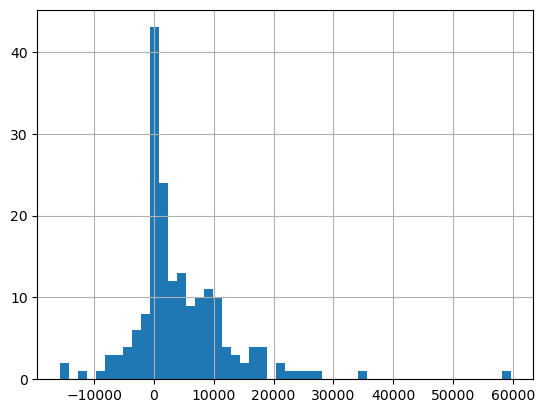

In [37]:
# naive analysis supposes that all people who received the treatment are equal
treated = df[df["treat"] == 1].copy()
treated["increase"] = treated['re78'] - (treated['re75'] + treated['re74']) / 2

avg_increase_treated = treated['increase'].mean()
print("Average increase in salary in 1978 when compared with the average from 1974-1975 for trained people: ", treated['increase'].mean())
print("Median increase in salary in 1978 when compared with the average from 1974-1975 for trained people: ", treated['increase'].median())

treated['increase'].hist(bins = 50)
plt.show()

Average increase in salary in 1978 when compared with the average from 1974-1975 for non trained people:  2941.309267552447
Median increase in salary in 1978 when compared with the average from 1974-1975 for non trained people:  1708.5645


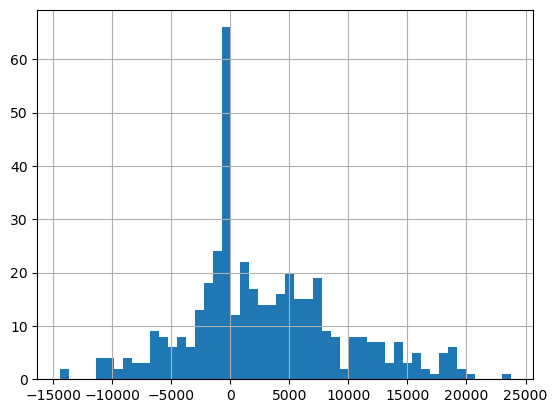

In [38]:
non_treated = df[df["treat"] == 0].copy()
non_treated["increase"] = non_treated['re78'] - (non_treated['re75'] + non_treated['re74']) / 2

avg_increase_non_treated = non_treated['increase'].mean()
print("Average increase in salary in 1978 when compared with the average from 1974-1975 for non trained people: ", non_treated['increase'].mean())
print("Median increase in salary in 1978 when compared with the average from 1974-1975 for non trained people: ", non_treated['increase'].median())

non_treated['increase'].hist(bins = 50)
plt.show()


In [39]:
# I would conclude that on average people earned more money than before after getting the training
# this is also somewhat fairly distributed with also the median person earning more
stats.ttest_ind(treated['increase'], non_treated['increase'])
# also we see that the p-value for the increase in income in treated and non treated individuals being the same is 0.01
# which suggests we could reject the null hypothesis that the income is the same

TtestResult(statistic=np.float64(2.5254573011301145), pvalue=np.float64(0.01180613328020044), df=np.float64(612.0))

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

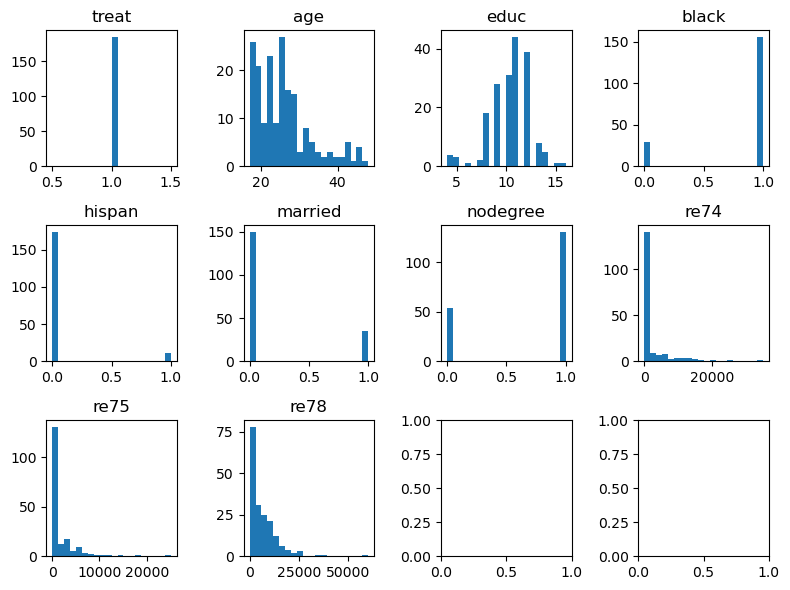

In [40]:
columns = [col for col in df.columns if col != "id"]
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

for i in range(3):
    for j in range(4):
        column_idx = j + i * 4
        if column_idx >= len(columns):
            continue

        column = columns[column_idx]
        ax[i, j].hist(treated[column], bins = 20)
        ax[i, j].set_title(column)

fig.tight_layout()
plt.show()

In [41]:
treated.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,increase
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,4535.329029
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218,8396.845834
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15719.533000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.000000
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,2321.107000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,8173.908000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,59665.890500


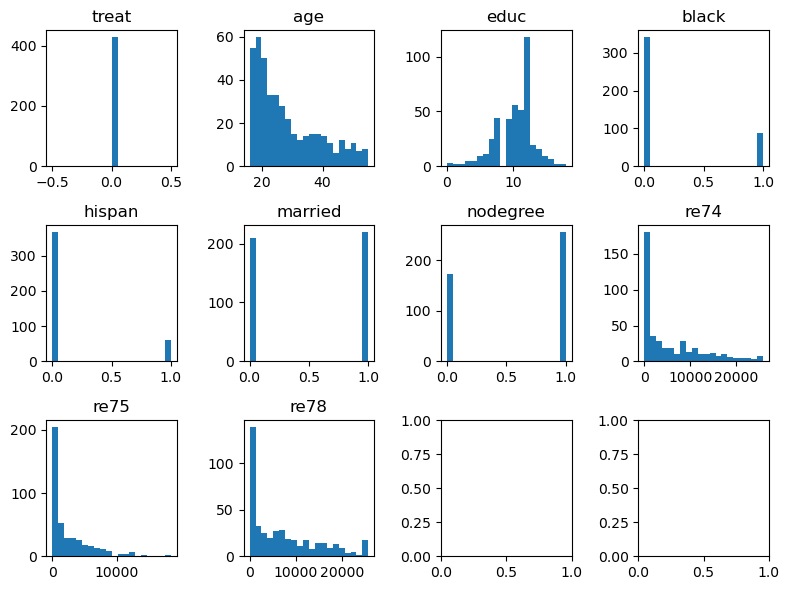

In [42]:
columns = [col for col in df.columns if col != "id"]
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

for i in range(3):
    for j in range(4):
        column_idx = j + i * 4
        if column_idx >= len(columns):
            continue

        column = columns[column_idx]
        ax[i, j].hist(non_treated[column], bins = 20)
        ax[i, j].set_title(column)

fig.tight_layout()
plt.show()

In [43]:
non_treated.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,increase
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742,2941.309268
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791,6581.952966
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14427.680000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300,-752.358500
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000,1708.564500
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000,6776.566500
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000,23764.800000


In [44]:
# you could see that people not being treated are on average already earning way more than people being treated
# which makes it harder you could say to increase wealth, in the case of treated people they were poor
# Also, they are more educated (nodegree average being lower), they are also older on average

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [45]:
# logit is logistic regression. The other parameters are the same as before

std_df = df.copy()
for column in columns:
    if len(df[column].unique()) > 2:
        std_df[column] = (std_df[column] - std_df[column].mean()) / std_df[column].std()

mod = smf.logit(formula='treat ~ age + re74 + re75 + educ + C(black) + C(hispan) +\
                        C(married) + C(nodegree)', data=std_df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sun, 19 Oct 2025   Pseudo R-squ.:                  0.3508
Time:                        15:57:47   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

In [46]:
std_df["propensity"] = res.predict(std_df)
std_df.sample(n=10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
143,NSW144,1,1.886090,-0.863185,1,0,0,1,-0.214865,0.124340,-0.909260,0.725453
34,NSW35,1,-0.239161,0.658697,1,0,0,0,-0.703546,-0.662971,-0.482025,0.660792
257,PSID73,0,-0.036756,0.658697,0,1,1,0,2.013976,0.921641,2.512717,0.039169
188,PSID4,0,1.481280,0.278227,0,0,1,1,2.659709,3.665512,1.164300,0.038500
465,PSID281,0,-1.048780,-0.102244,0,0,0,1,-0.703546,-0.607561,-0.049414,0.106185
65,NSW66,1,0.064446,-0.482714,1,0,0,1,-0.703546,-0.662971,0.522232,0.718602
276,PSID92,0,-0.542768,0.278227,0,0,1,1,0.649015,0.691310,0.515312,0.042195
316,PSID132,0,-0.441566,-0.102244,0,0,1,1,1.737233,0.291490,-0.052776,0.020953
497,PSID313,0,0.671661,0.658697,0,0,0,0,0.550718,-0.662971,-0.101831,0.055214
613,PSID429,0,-1.149982,-0.482714,0,0,0,1,-0.703546,-0.662971,-0.709084,0.089712


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [47]:
# Separate treated and control groups
treated = std_df[std_df['treat'] == 1]
control = std_df[std_df['treat'] == 0]

# Create graph for matching
G = nx.Graph()

# Add edges between all treated and control pairs with weight as similarity (1 / (1 + abs(diff)))
for t_idx in treated.index:
    for c_idx in control.index:
        diff = abs(treated.loc[t_idx, 'propensity'] - control.loc[c_idx, 'propensity'])
        similarity = 1 / (1 + diff)
        G.add_edge(t_idx, c_idx, weight=similarity)

# Find maximum weight matching
matching = nx.max_weight_matching(G)

# Extract matched pairs (only treated to control)
matched_pairs = [(t, c) for t, c in matching if t in treated.index and c in control.index]

# Create matched dataset
matched_treated = treated.loc[[t for t, c in matched_pairs]]
matched_control = control.loc[[c for t, c in matched_pairs]]

# Compare outcomes (re78)
print("Treated re78 mean:", matched_treated['re78'].mean())
print("Control re78 mean:", matched_control['re78'].mean())

Treated re78 mean: -0.04492038672712163
Control re78 mean: 0.17544877590385596


In [48]:
matched_treated.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
count,36.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,1.0,-0.362853,-0.038832,0.916667,0.083333,0.083333,0.722222,-0.491323,-0.313741,-0.044920,0.636903
std,0.0,0.571521,0.758218,0.280306,0.280306,0.280306,0.454257,0.576345,1.034755,0.956110,0.135672
min,1.0,-1.048780,-2.385067,0.000000,0.000000,0.000000,0.000000,-0.703546,-0.662971,-0.909260,0.206570
25%,1.0,-0.947578,-0.482714,1.000000,0.000000,0.000000,0.000000,-0.703546,-0.662971,-0.807783,0.633241
50%,1.0,-0.340363,0.087992,1.000000,0.000000,0.000000,1.000000,-0.703546,-0.662971,-0.262884,0.670301
75%,1.0,0.165649,0.658697,1.000000,0.000000,0.000000,1.000000,-0.703546,-0.662971,0.416621,0.716919
max,1.0,0.975268,1.039168,1.000000,1.000000,1.000000,1.000000,1.421466,4.791490,2.680429,0.776324


In [49]:
matched_control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
count,36.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.0,-0.334741,0.309933,0.500000,0.250000,0.194444,0.638889,-0.281509,-0.171118,0.175449,0.385753
std,0.0,1.067179,1.100362,0.507093,0.439155,0.401386,0.487136,0.807557,0.911883,0.994001,0.246343
min,0.0,-1.149982,-1.243655,0.000000,0.000000,0.000000,0.000000,-0.703546,-0.662971,-0.909260,0.100891
25%,0.0,-1.048780,-0.482714,0.000000,0.000000,0.000000,0.000000,-0.703546,-0.662971,-0.909260,0.180284
50%,0.0,-0.846375,0.278227,0.500000,0.000000,0.000000,1.000000,-0.703546,-0.662971,0.001421,0.303888
75%,0.0,0.115048,0.658697,1.000000,0.250000,0.000000,1.000000,-0.412664,-0.074785,1.110844,0.646269
max,0.0,2.695709,2.941520,1.000000,1.000000,1.000000,1.000000,2.048456,3.207567,2.271795,0.753646


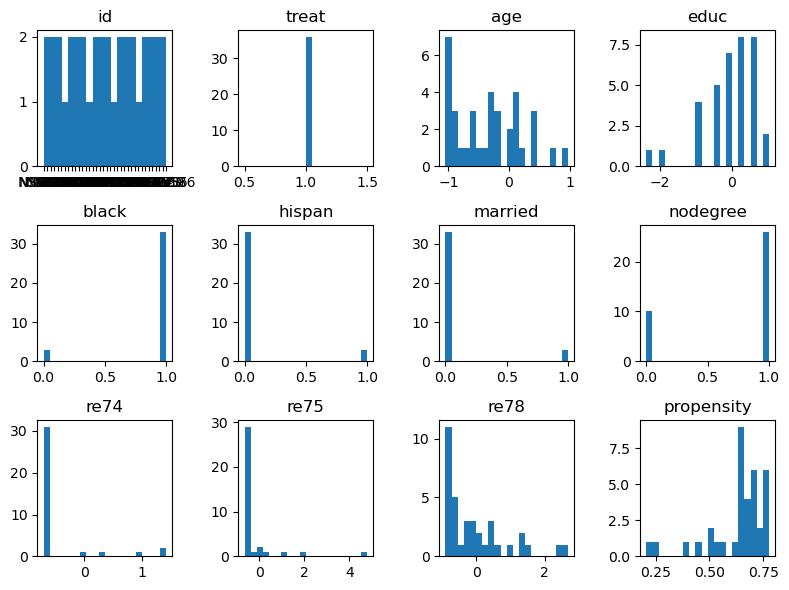

In [50]:
columns = std_df.columns
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

for i in range(3):
    for j in range(4):
        column_idx = j + i * 4
        if column_idx >= len(columns):
            continue

        column = columns[column_idx]
        ax[i, j].hist(matched_treated[column], bins = 20)
        ax[i, j].set_title(column)

fig.tight_layout()
plt.show()

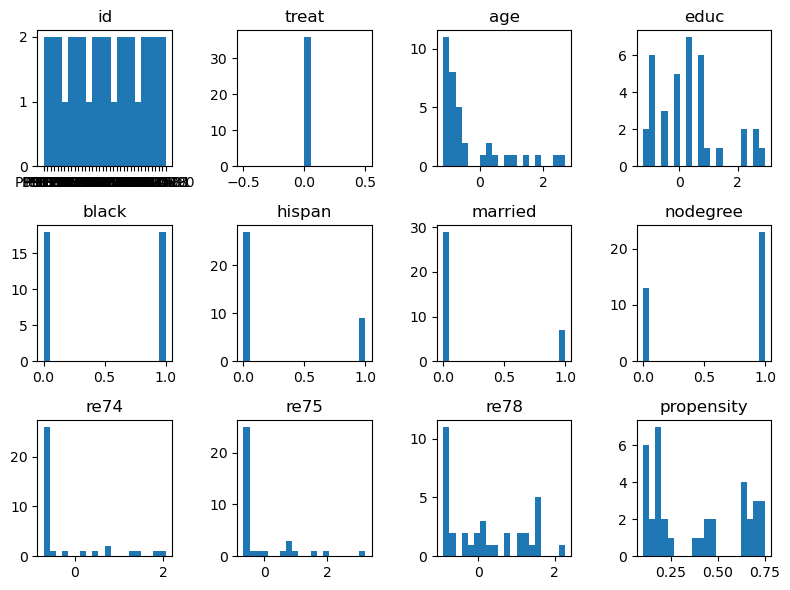

In [51]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

for i in range(3):
    for j in range(4):
        column_idx = j + i * 4
        if column_idx >= len(columns):
            continue

        column = columns[column_idx]
        ax[i, j].hist(matched_control[column], bins = 20)
        ax[i, j].set_title(column)

fig.tight_layout()
plt.show()

In [52]:
# For comparison, compute average absolute differences for random pairs
np.random.seed(42)  # for reproducibility
random_treated = np.random.choice(treated.index, size=len(matched_pairs), replace=False)
random_control = np.random.choice(control.index, size=len(matched_pairs), replace=False)

# Compute average absolute differences within matched pairs for each feature
pair_diffs = {}
random_pair_diffs = {}
for col in columns:
    if col not in ['id', 'treat', 're78', 'propensity']:
        diffs = []
        for t, c in matched_pairs:
            diff = abs(std_df.loc[t, col] - std_df.loc[c, col])
            diffs.append(diff)
        pair_diffs[col] = np.mean(diffs)

        random_diffs = []
        for t, c in zip(random_treated, random_control):
            random_diff = abs(std_df.loc[t, col] - std_df.loc[c, col])
            random_diffs.append(random_diff)
        random_pair_diffs[col] = np.mean(random_diffs)

print("Average absolute differences within matched pairs:")
for col, diff in pair_diffs.items():
    print(f"{col}: {diff:.3f}")

print("\nAverage absolute differences for random pairs:")
for col, diff in random_pair_diffs.items():
    print(f"{col}: {diff:.3f}")

# The matched pairs have smaller differences than random pairs, showing better balance.

Average absolute differences within matched pairs:
age: 0.647
educ: 0.772
black: 0.472
hispan: 0.278
married: 0.222
nodegree: 0.306
re74: 0.374
re75: 0.630

Average absolute differences for random pairs:
age: 1.254
educ: 1.015
black: 0.611
hispan: 0.139
married: 0.389
nodegree: 0.528
re74: 1.116
re75: 0.825


## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [53]:
# The categorical feature with the highest difference amongst matched pairs in the previous algorithm is black
# We should not consider continuous features because it's difficult to find matches for the same exact value

# Separate treated and control groups
treated = std_df[std_df['treat'] == 1]
control = std_df[std_df['treat'] == 0]

# Create graph for matching
G = nx.Graph()

# Add edges between all treated and control pairs with weight as similarity (1 / (1 + abs(diff)))
for t_idx in treated.index:
    for c_idx in control.index:
        if treated.loc[t_idx, 'black'] == control.loc[c_idx, 'black']:
            diff = abs(treated.loc[t_idx, 'propensity'] - control.loc[c_idx, 'propensity'])
            similarity = 1 / (1 + diff)
            G.add_edge(t_idx, c_idx, weight=similarity)

# Find maximum weight matching
matching = nx.max_weight_matching(G)

# Extract matched pairs (only treated to control)
matched_pairs = [(t, c) for t, c in matching if t in treated.index and c in control.index]

# Create matched dataset
matched_treated = treated.loc[[t for t, c in matched_pairs]]
matched_control = control.loc[[c for t, c in matched_pairs]]

# Compare outcomes (re78)
print("Treated re78 mean:", matched_treated['re78'].mean())
print("Control re78 mean:", matched_control['re78'].mean())

Treated re78 mean: -0.3424389109337123
Control re78 mean: -0.1803588145724935


In [54]:
# For comparison, compute average absolute differences for random pairs
np.random.seed(42)  # for reproducibility
random_treated = np.random.choice(treated.index, size=len(matched_pairs), replace=False)
random_control = np.random.choice(control.index, size=len(matched_pairs), replace=False)

# Compute average absolute differences within matched pairs for each feature
pair_diffs = {}
random_pair_diffs = {}
for col in columns:
    if col not in ['id', 'treat', 're78', 'propensity']:
        diffs = []
        for t, c in matched_pairs:
            diff = abs(std_df.loc[t, col] - std_df.loc[c, col])
            diffs.append(diff)
        pair_diffs[col] = np.mean(diffs)

        random_diffs = []
        for t, c in zip(random_treated, random_control):
            random_diff = abs(std_df.loc[t, col] - std_df.loc[c, col])
            random_diffs.append(random_diff)
        random_pair_diffs[col] = np.mean(random_diffs)

print("Average absolute differences within matched pairs:")
for col, diff in pair_diffs.items():
    print(f"{col}: {diff:.3f}")

print("\nAverage absolute differences for random pairs:")
for col, diff in random_pair_diffs.items():
    print(f"{col}: {diff:.3f}")

# The matched pairs have smaller differences than random pairs, showing better balance.

Average absolute differences within matched pairs:
age: 0.599
educ: 0.666
black: 0.000
hispan: 0.042
married: 0.208
nodegree: 0.208
re74: 0.464
re75: 0.895

Average absolute differences for random pairs:
age: 1.252
educ: 1.189
black: 0.583
hispan: 0.167
married: 0.333
nodegree: 0.583
re74: 1.006
re75: 0.737


## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [57]:
income_increase_sum = 0
for t, c in matched_pairs:
    treated = df.loc[t]
    control = df.loc[c]

    treated_increase = treated['re78'] - treated['re74':'re75'].mean()
    control_increase = control['re78'] - control['re74':'re75'].mean()

    income_increase_sum += treated_increase - control_increase

print("Difference in income increase in 1978 (when compared with the average of 1975 and 1974) between matched pairs of people who received the training and people who did not: ", income_increase_sum / len(matched_pairs))
print("Difference in income increase in 1978 (when compared with the average of 1975 and 1974) between people who received the training and people who did not: ", avg_increase_treated - avg_increase_non_treated)

Difference in income increase in 1978 (when compared with the average of 1975 and 1974) between matched pairs of people who received the training and people who did not:  376.98524312499944
Difference in income increase in 1978 (when compared with the average of 1975 and 1974) between people who received the training and people who did not:  1594.0197615016064
